In [61]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import umap #umap-learn

In [ ]:
#!/usr/bin/env python3
"""
Generate protein_family.npy file for UMAP visualization
"""
import pandas as pd
import numpy as np
import os

# Edit these variables
input_csv = "../data/car_t_mrna_dataset.csv"
output_file = "/Users/brik/Projects/ML/CodonBERT/output/processed/protein_families.npy"
embedding_file = "/Users/brik/Projects/ML/CodonBERT/output/processed/embeddings.npy"

# Load the embedding to check its size
embedding_data = np.load(embedding_file, allow_pickle=True)
embedding_length = len(embedding_data)
print(f"Embedding has {embedding_length} entries")

# Read CSV file
print(f"Reading {input_csv}...")
df = pd.read_csv(input_csv)

# Extract protein family column - ensure it's the same length as embedding
if len(df) != embedding_length:
    print(f"WARNING: CSV has {len(df)} rows but embedding has {embedding_length} entries")
    print("Attempting to truncate protein_family to match embedding length")
    if len(df) > embedding_length:
        # Truncate to match embedding size
        df = df.iloc[:embedding_length]
    else:
        print("ERROR: CSV has fewer entries than embedding - cannot align")
        exit(1)

# Extract protein family column
protein_family = df['protein_family'].values

# Double-check alignment
print(f"protein_family array has {len(protein_family)} entries")
assert len(protein_family) == embedding_length, "Arrays still misaligned!"

# Save as NPY
np.save(output_file, protein_family)
print(f"Successfully saved {output_file} with {len(protein_family)} entries")

# Print unique protein families for reference
unique_families = pd.Series(protein_family).value_counts()
print("\nProtein family distribution:")
for family, count in unique_families.items():
    print(f"  {family}: {count}")

Embedding has 78 entries
Reading ../data/car_t_mrna_dataset.csv...
Attempting to truncate protein_family to match embedding length


KeyError: 'functional_categories'

In [ ]:
data_list = []

data = embedding_data
# Iterate over each sequence in mires
for sequence in data:
    # Compute the mean along the 0th axis
    avg_embedding = np.mean(np.array(sequence), axis=0)
    data_list.append(avg_embedding)

# Convert avg_mires to a numpy array for further processing, just in case
data_list = np.array(data_list)

print("Shape:", data_list.shape)
# This should print Shape of avg_mires of ({number_of_records}, 768) "Hopefully!"


Shape: (78, 768)


In [ ]:
data = data_list
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(data)

/opt/homebrew/Caskroom/mambaforge/base/envs/codonbert/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42)
# embedding = tsne.fit_transform(data)

In [ ]:
embedding.shape

(78, 2)

In [ ]:
# Load the protein family data
protein_family = np.load("/Users/brik/Projects/ML/CodonBERT/output/processed/protein_families.npy", allow_pickle=True)

# Count the occurrences of each protein family
string_counts = Counter(protein_family)

# Define the occurrence threshold
occurrence_threshold = 3  # Adjust based on your data

# Replace protein families with few occurrences with "other"
filtered_protein_family = [family if string_counts[family] >= occurrence_threshold else "other" for family in protein_family]

# Assign colors to protein families
unique_protein_family = np.unique(filtered_protein_family)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_protein_family)))
protein_family_to_color = {family: color for family, color in zip(unique_protein_family, colors)}
point_colors = np.array([protein_family_to_color.get(family, 'gray') for family in filtered_protein_family])

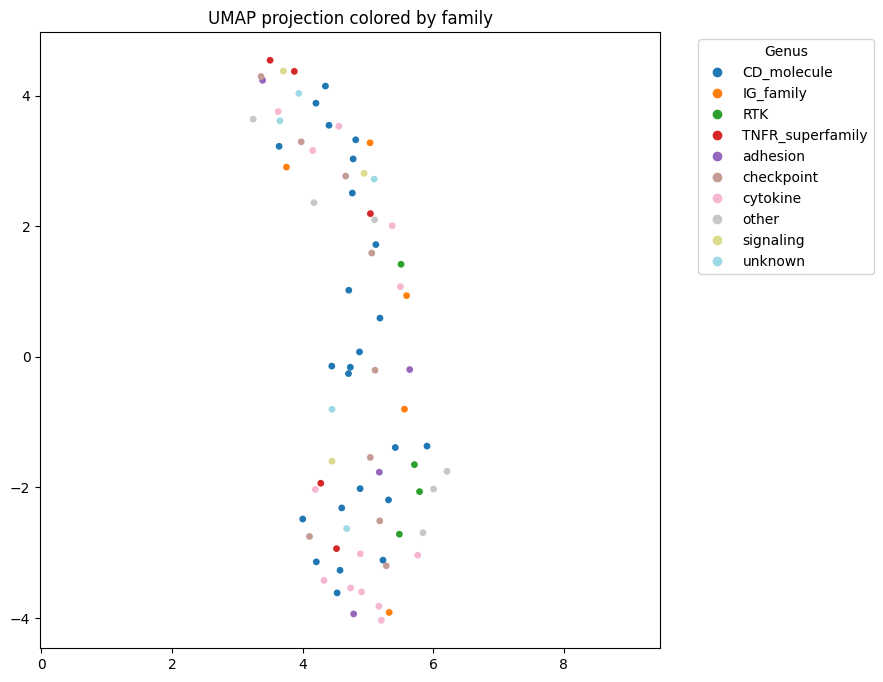

In [ ]:
# Now create the scatter plot with colored points
plt.figure(figsize=(8, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=point_colors, s=15)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection colored by family', fontsize=12)

# Create a legend
# Create a legend handle for each genus
legend_handles = [plt.Line2D([0], [0], marker='o', color=color, label=genus, linestyle='None')
                  for genus, color in protein_family_to_color.items()]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Genus')

plt.show()

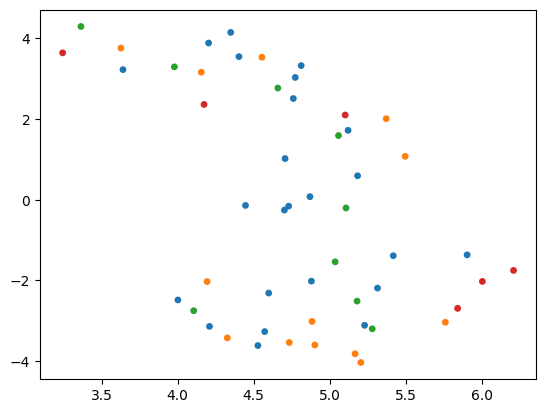

In [ ]:
# Sort families by frequency
family_counts = Counter(filtered_protein_family)
sorted_families = sorted(family_counts.items(), key=lambda x: x[1], reverse=True)
sorted_unique_families = [f[0] for f in sorted_families]

# Use a better colormap
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_unique_families)))
protein_family_to_color = {family: color for family, color in zip(sorted_unique_families, colors)}

# Show only families with more than X members
major_families = [f for f in filtered_protein_family if family_counts[f] > 5]
mask = np.isin(filtered_protein_family, major_families)
plt.scatter(embedding[mask, 0], embedding[mask, 1], c=[protein_family_to_color[f] for f in np.array(filtered_protein_family)[mask]], s=15)